# Методы сбора и обработки данных из Интернет

## Урок 3. Парсинг данных. Системы управления базами данных MongoDB и SQLite в Python

***Собрать информацию о вакансиях на вводимую должность с сайтов hh.ru и superjob.ru***

Список будет содержать в себе:

- vacancy_name - Наименование вакансии
- company_name - Наименование работодателя
- city - Населенный пункт
- metro station - Станция метро
- salary_min - Предлагаемая минимальная заработная плата
- salary_max - Предлагаемая максимальная заработная плата
- salary_currency - Валюта заработной платы
- link - Ссылка на вакансию
- site - Сайт, откуда собрана вакансия

In [32]:
from bs4 import BeautifulSoup as bs
from pprint import pprint
from pymongo import MongoClient
import re
import requests

In [40]:
class ParsingVacancy():

    def __init__(self, db_name, collection_name):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
        AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'
        }
        self.link_hh = 'https://hh.ru/search/vacancy'
        self.link_superjob = 'https://www.superjob.ru/vacancy/search/'

        self.mongodb = MongoClient('localhost',27017)
        self.db = self.mongodb[db_name]  # указать имя базы данных, которая будет создана
        self.collection = self.db[collection_name]  # создать объект, в которую складывается коллекция

    # Функция print_salary производит поиск и выводит на экран вакансии с заработной платой больше введенной суммы
    # Поиск выполняется по двум полям: минимальная заработная плата, максимальная заработная плата
    def print_salary(self, salary):
        objects = self.collection.find({'$or': [ {'salary_min': {'$gt': salary}}, {'salary_max': {'$gt': salary}} ]})
        for obj in objects:
            pprint(obj)
    
    # Функция print_salary_city производит поиск и выводит на экран вакансии
    # с заработной платой больше определенной суммы в заданной валюте, в определенном городе
    def print_salary_city(self, salary, currency='', city=''):
        objects = self.collection.find({'salary_currency': currency, 'city': city, '$or': [ {'salary_min': {'$gt': salary}}, {'salary_max': {'$gt': salary}} ]})
        for obj in objects:
            pprint(obj)

    # Функция parser_vacancy записывает собранные вакансии в созданную базу данных MongoDB
    def parser_vacancy(self, vacancy):
        self._parser_hh(vacancy)
        self._parser_superjob(vacancy)

    def _parser_hh(self, vacancy):
        params = {
            'text': vacancy,
            'L_save_area': True,
            'clusters': True,
            'enable_snippets': True,
            'search_field': 'name',
            'showClusters': True,
            'page': ''
        }

        response = self._get_response(self.link_hh, params)

        last_page = self._get_last_page_hh(response)

        for page in range(0, last_page):
            params['page'] = page
            response = self._get_response(self.link_hh, params)

            if response.ok:
                soup = self._get_parsed_response(response)

                vacancy_items = soup.find('div', {'data-qa': 'vacancy-serp__results'}) \
                                            .find_all('div', {'class': 'vacancy-serp-item'})
                for item in vacancy_items:
                    vacancy = self._parser_item_hh(item)

                    if self._is_exists('vacancy_link', vacancy['vacancy_link']):
                        self.collection.update_one({'vacancy_link': vacancy['vacancy_link']}, {'$set': vacancy})
                    else:
                        self.collection.insert_one(vacancy)

    def _parser_superjob(self, vacancy):
        params = {
            'keywords': vacancy,
            'profession_only': '1',
            'page': ''
        }

        response = self._get_response(self.link_superjob, params)

        last_page = self._get_last_page_superjob(response)

        for page in range(0, last_page + 1):
            params['page'] = page
            response = self._get_response(self.link_superjob, params)

            if response.ok:
                soup = self._get_parsed_response(response)

                vacancy_items = soup.find_all('div', {'class': 'f-test-vacancy-item'})

                for item in vacancy_items:
                    vacancy = self._parser_item_superjob(item)

                    if self._is_exists('vacancy_link', vacancy['vacancy_link']):
                        self.collection.update_one({'vacancy_link': vacancy['vacancy_link']}, {'$set': vacancy})
                    else:
                        self.collection.insert_one(vacancy)

    def _parser_item_hh(self, item):
        vacancy_data = {}

        # vacancy_name
        vacancy_name = item.find('span', {'class': 'resume-search-item__name'}) \
            .getText().replace(u'\xa0', u' ')

        vacancy_data['vacancy_name'] = vacancy_name

        # company_name
        company_name = item.find('div', {'class': 'vacancy-serp-item__meta-info'}) \
                            .getText() \
                            .replace(u'\xa0', u' ')

        vacancy_data['company_name'] = company_name

        # city
        city = item.find('span', {'class': 'vacancy-serp-item__meta-info'}) \
                    .getText() \
                    .split(', ')[0]

        vacancy_data['city'] = city

        #salary
        salary = item.find('span', {'data-qa': 'vacancy-serp__vacancy-compensation'})

        if not salary:
            salary_min = None
            salary_max = None
            salary_currency = None

        else:
            salary = salary.getText().replace(u'\xa0', u'')

            salary = re.split(r'\s|-', salary)

            if salary[0] == 'до':
                salary_min = None
                salary_max = int(salary[1])
            elif salary[0] == 'от':
                salary_min = int(salary[1])
                salary_max = None
            else:
                salary_min = int(salary[0])
                salary_max = int(salary[1])

            salary_currency = salary[2]
            salary_currency = self._get_name_currency(salary_currency)

        vacancy_data['salary_min'] = salary_min
        vacancy_data['salary_max'] = salary_max
        vacancy_data['salary_currency'] = salary_currency

        # link
        is_ad = item.find('a', {'data-qa': 'vacancy-serp__vacancy_response'}).getText()

        vacancy_link = item.find('span', {'class': 'resume-search-item__name'}).find('a')['href']

        if is_ad != 'Реклама':
            vacancy_link = vacancy_link.split('?')[0]

        vacancy_data['vacancy_link'] = vacancy_link

        # site
        vacancy_data['site'] = 'hh.ru'

        return vacancy_data

    def _parser_item_superjob(self, item):
        vacancy_data = {}

        # vacancy_name
        vacancy_name = item.find_all('a')
        vacancy_name = vacancy_name[0].getText()
        vacancy_data['vacancy_name'] = vacancy_name

        # company_name
        company_name = item.find('span', {'class': 'f-test-text-vacancy-item-company-name'})

        if not company_name:
            company_name = None
        else:
            company_name = company_name.getText()

        vacancy_data['company_name'] = company_name

        # city
        company_location = item.find('span', {'class': 'f-test-text-company-item-location'}) \
                                .findChildren()[2] \
                                .getText() \
                                .split(',')

        vacancy_data['city'] = company_location[0]

        #salary
        salary = item.find('span', {'class': 'f-test-text-company-item-salary'}) \
                      .findChildren()
        if not salary or len(salary) == 1 or len(salary) == 5:
            salary_min = None
            salary_max = None
            salary_currency = None

        else:
            is_check_salary = item.find('span', {'class': 'f-test-text-company-item-salary'}) \
                .getText() \
                .replace(u'\xa0', u' ') \
                .split(' ', 1)[0]
            salary = salary[0].getText().replace(u'\xa0', u' ')
            salary_string = re.sub('(?<=\d)\s(?=\d)', '', salary)
            salary_string = salary_string.lower()
            words = re.findall(r'\w+', salary_string)

            if is_check_salary == 'до' or len(salary) == 2:
                salary_min = None
                salary_max = words[1]
                salary_currency = salary.split()[-1]
            elif is_check_salary == 'от':
                salary_min = words[1]
                salary_max = None
                salary_currency = salary.split()[-1]
            elif is_check_salary == 'По':
                pass
            else:
                salary_min = words[0]
                salary_max = words[1]
                salary_currency = salary.split()[-1]

        vacancy_data['salary_min'] = salary_min
        vacancy_data['salary_max'] = salary_max
        vacancy_data['salary_currency'] = salary_currency

        # link
        vacancy_link = item.find('a', {'class': 'icMQ_'})

        if vacancy_link:
            vacancy_link = vacancy_link['href']
            vacancy_data['vacancy_link'] = f'https://russia.superjob.ru{vacancy_link}'

        # site
        vacancy_data['site'] = 'www.superjob.ru'

        return vacancy_data

    def _get_last_page_hh(self, response):
        soup = self._get_parsed_response(response)

        if soup:
            page_block = soup.find('div', {'data-qa': 'pager-block'})
            if not page_block:
                last_page = 1
            else:
                last_page = int(
                    page_block.find_all('a', {'class': 'HH-Pager-Control'})[-2] \
                                .getText()
                                )

        return last_page

    def _get_last_page_superjob(self, response):
        soup = self._get_parsed_response(response)

        if soup:
            page_block = soup.find('a', {'class': 'f-test-button-1'})
            if not page_block:
                last_page = 1
            else:
                page_block = page_block.findParent()
                last_page = int(
                    page_block.find_all('a')[-2] \
                                .getText()
                )

        return last_page

    def _get_parsed_response(self, response):
        if response.ok:
            soup = bs(response.text,'lxml')
            return soup

    def _get_response(self, link, params=None):
        response = requests.get(link, params=params, headers=self.headers)
        return response

    def _is_exists(self, name_tags, field):
        return bool(self.collection.find_one({name_tags: { "$in": [field]}}))

    def _get_name_currency(self, currency_name):
        currency_dict  = {
            'EUR': {' €'}, \
            'KZT': {' ₸'}, \
            'RUB': {' ₽', 'руб.'}, \
            'UAH': {' ₴', 'грн.'}, \
            'USD': {' $'}
        }

        name = currency_name

        for item_name, items_list in currency_dict.items():
            if currency_name in items_list:
                name = item_name

        return name

### Задание 1. Развернуть у себя на компьютере/виртуальной машине/хостинге MongoDB и реализовать функцию, записывающую собранные вакансии в созданную БД (без датафрейма)

In [45]:
vacancy_db = ParsingVacancy('vacancy_db', 'VacancyMongo')
vacancy = 'Data Scientist'
vacancy_db.parser_vacancy(vacancy)

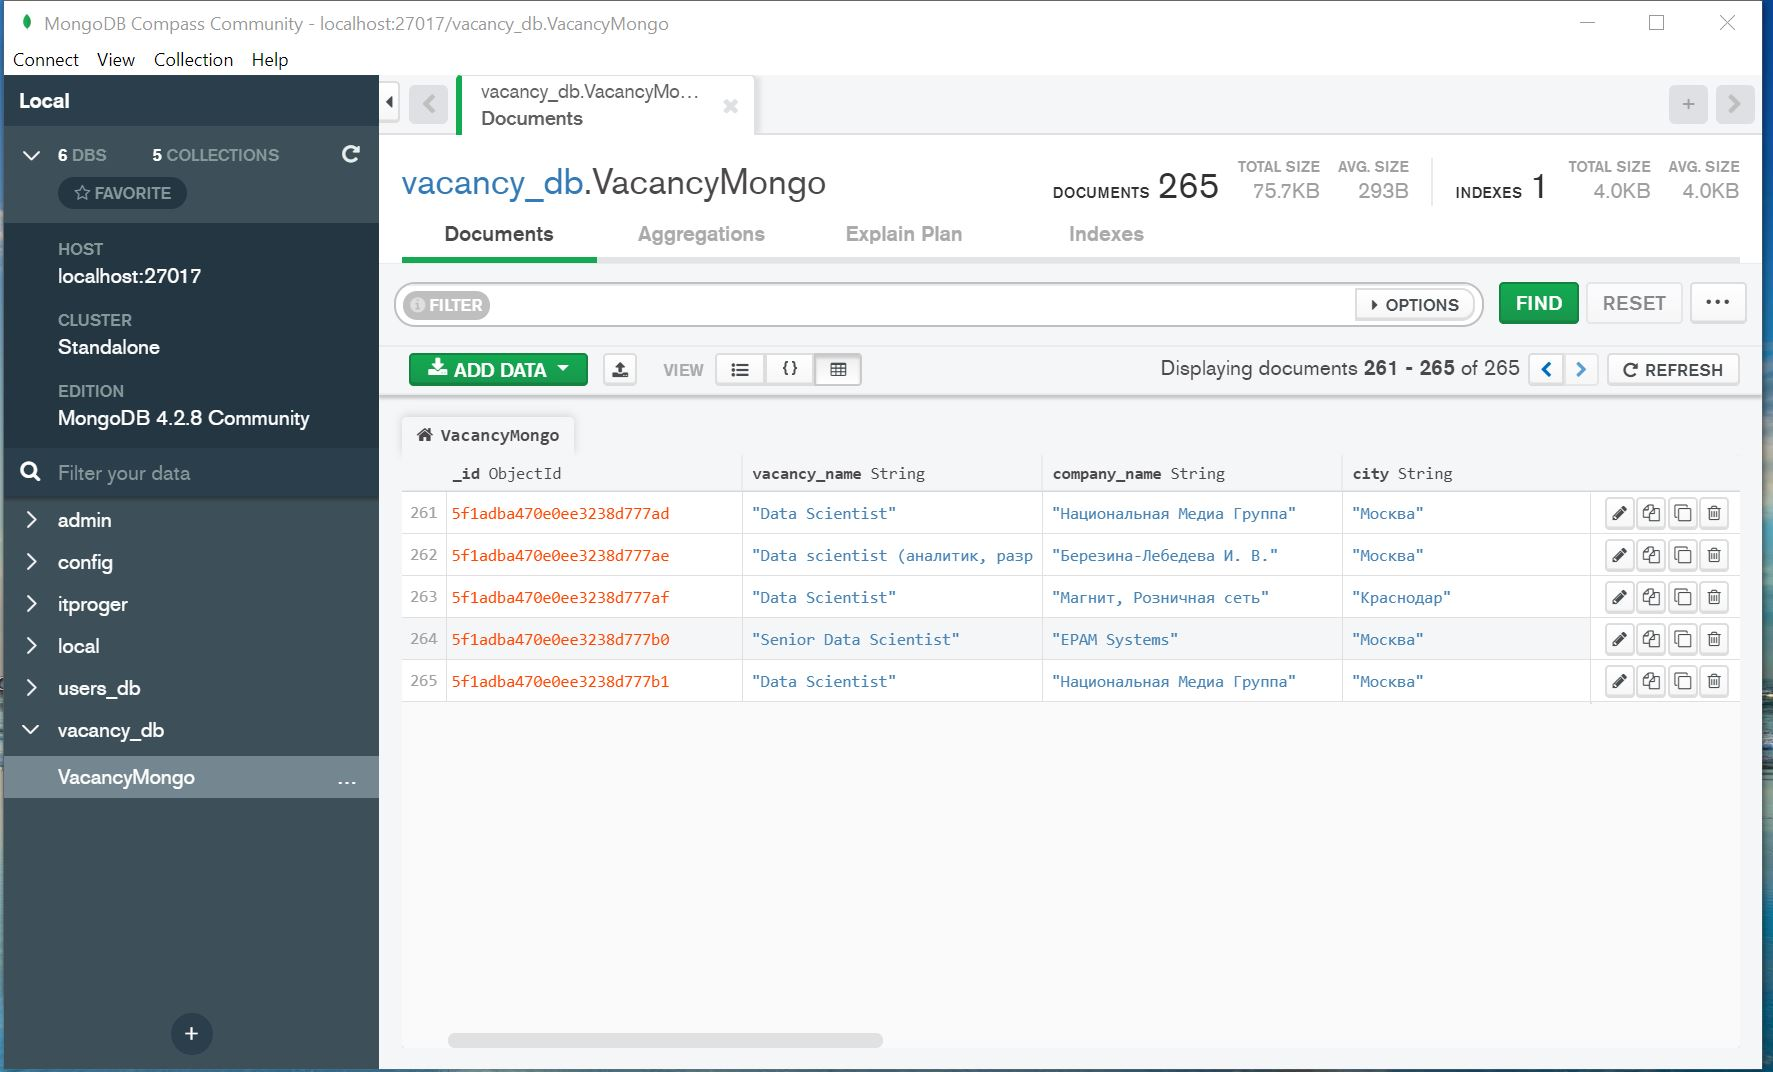

### Задание 2. Написать функцию, которая производит поиск и выводит на экран вакансии с заработной платой больше введенной суммы. 

Функция print_salary производит поиск и выводит на экран вакансии с заработной платой больше введенной суммы.
Поиск выполняется по двум полям: минимальная заработная плата, максимальная заработная плата

In [42]:
vacancy_db.print_salary(150000)

{'_id': ObjectId('5f1c1d032d60571eacc72ff6'),
 'city': 'Москва',
 'company_name': ' Tevian (ООО Технологии видеоанализа) ',
 'salary_currency': 'RUB',
 'salary_max': 200000,
 'salary_min': 90000,
 'site': 'hh.ru',
 'vacancy_link': 'https://hh.ru/vacancy/38090271',
 'vacancy_name': 'Data Scientist (Computer Vision)'}
{'_id': ObjectId('5f1c1d032d60571eacc72ff8'),
 'city': 'Алматы',
 'company_name': 'ТОО One technologies ',
 'salary_currency': 'KZT',
 'salary_max': 900000,
 'salary_min': 650000,
 'site': 'hh.ru',
 'vacancy_link': 'https://hh.ru/vacancy/38159690',
 'vacancy_name': 'ML Developer/Data scientist'}
{'_id': ObjectId('5f1c1d032d60571eacc72ff9'),
 'city': 'Москва',
 'company_name': 'ООО СКАЙТРЭК ',
 'salary_currency': 'RUB',
 'salary_max': 180000,
 'salary_min': 120000,
 'site': 'hh.ru',
 'vacancy_link': 'https://hh.ru/vacancy/37782747',
 'vacancy_name': 'Data Scientist'}
{'_id': ObjectId('5f1c1d032d60571eacc72ffa'),
 'city': 'Москва',
 'company_name': ' Gradient ',
 'salary_curr

Функция print_salary_city производит поиск и выводит на экран вакансии с заработной платой больше определенной суммы в заданной валюте, в определенном городе

In [44]:
vacancy_db.print_salary_city(150000,'RUB', 'Москва')

{'_id': ObjectId('5f1c1d032d60571eacc72ff6'),
 'city': 'Москва',
 'company_name': ' Tevian (ООО Технологии видеоанализа) ',
 'salary_currency': 'RUB',
 'salary_max': 200000,
 'salary_min': 90000,
 'site': 'hh.ru',
 'vacancy_link': 'https://hh.ru/vacancy/38090271',
 'vacancy_name': 'Data Scientist (Computer Vision)'}
{'_id': ObjectId('5f1c1d032d60571eacc72ff9'),
 'city': 'Москва',
 'company_name': 'ООО СКАЙТРЭК ',
 'salary_currency': 'RUB',
 'salary_max': 180000,
 'salary_min': 120000,
 'site': 'hh.ru',
 'vacancy_link': 'https://hh.ru/vacancy/37782747',
 'vacancy_name': 'Data Scientist'}
{'_id': ObjectId('5f1c1d032d60571eacc72ffa'),
 'city': 'Москва',
 'company_name': ' Gradient ',
 'salary_currency': 'RUB',
 'salary_max': None,
 'salary_min': 300000,
 'site': 'hh.ru',
 'vacancy_link': 'https://hh.ru/vacancy/37935294',
 'vacancy_name': 'Senior Data Scientist'}
{'_id': ObjectId('5f1c1d032d60571eacc72ffc'),
 'city': 'Москва',
 'company_name': 'ООО КИБЕРТОНИКА ',
 'salary_currency': 'RUB',

### Задание 3. Написать функцию, которая будет добавлять в вашу базу данных только новые вакансии с сайта

Проверка на уникальность записи базы данных реализована в составе функций vacancy_db._parser_hh и vacancy_db._parser_superjob

Проверка для hh.ru
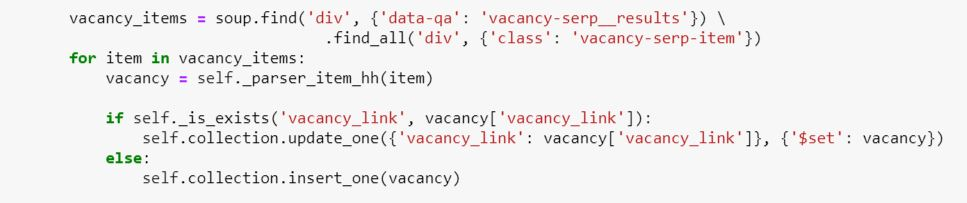

Проверка для superjob.ru
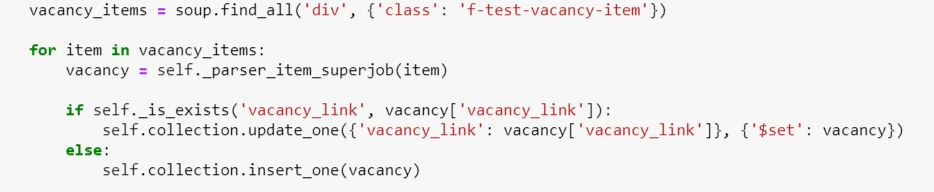

Проведем следующий тест:

1) изменить содержание первой записи созданной базы данных с помощью update_one

2) вывести на экран содержание измененной записи

3) выполнить функцию vacancy_db.parser_vacancy(), собирающую и записывающую собранные вакансии в базу данных

4) вывести на экран содеражание первой записи базы данных. 

Результат: содержание обновляется после выполнения функции.

In [46]:
vacancy_db.collection.update_one({'vacancy_link': 'https://hh.ru/vacancy/37732722'}, 
                                 {'$set': {'city':'Москва', 'company_name':'some compary'}})

In [47]:
objects = vacancy_db.collection.find().limit(1)
for obj in objects:
    pprint(obj)

{'_id': ObjectId('5f1c1d032d60571eacc72ff1'),
 'city': 'Москва',
 'company_name': 'some compary',
 'salary_currency': None,
 'salary_max': None,
 'salary_min': None,
 'site': 'hh.ru',
 'vacancy_link': 'https://hh.ru/vacancy/37732722',
 'vacancy_name': 'Специалист по углубленной аналитике данных (Data scientist)'}


In [48]:
vacancy = 'Data Scientist'
vacancy_db.parser_vacancy(vacancy)

In [49]:
objects = vacancy_db.collection.find().limit(1)
for obj in objects:
    pprint(obj)

{'_id': ObjectId('5f1c1d032d60571eacc72ff1'),
 'city': 'Минск',
 'company_name': ' А1. Информационные технологии, телеком ',
 'salary_currency': None,
 'salary_max': None,
 'salary_min': None,
 'site': 'hh.ru',
 'vacancy_link': 'https://hh.ru/vacancy/37732722',
 'vacancy_name': 'Специалист по углубленной аналитике данных (Data scientist)'}
